<a href="https://colab.research.google.com/github/wenhuipeng/fastai_practice/blob/main/04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 189 kB 40.9 MB/s 
     |████████████████████████████████| 1.2 MB 46.0 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 51 kB 289 kB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
#hide
Path.BASE_PATH = path

我们可以通过使用 ls 来查看这个目录中的内容，这是 fastai 添加的一个方法。这个方法返回一个叫做 L 的类，它具有与 Python 内置列表相同的所有功能，而且还有很多其他的功能。它的一个方便的特点是，当打印时，它在列出项目本身之前显示项目的数量 (如果有超过 10 个项目，它只显示前几个)。

在fastai中L类等同于list

In [6]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

MNIST数据集遵循机器学习数据集的常见布局：训练集和验证集（和/或测试集）的独立文件夹。让我们来看看训练集里面有什么。

In [7]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

有一个3的文件夹，和一个7的文件夹。用机器学习的说法，我们说 "3 "和 "7 "是这个数据集中的标签（或目标）。让我们看一下这些文件夹中的一个（使用排序以确保我们都得到相同的文件顺序）。

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

正如我们所期望的，它充满了图像文件。现在让我们看一看。这是一张手写数字3的图像，取自著名的MNIST手写数字数据集。

In [9]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

这里我们使用的是Python图像库（PIL）中的图像类，它是最广泛使用的Python包，用于打开、操作和查看图像。Jupyter知道PIL的图像，所以它为我们自动显示图像。

在计算机中，一切都以数字来表示。为了查看构成这个图像的数字，我们必须把它转换成NumPy数组或PyTorch张量。例如，这里是图像的一个部分，转换为NumPy数组的样子。

In [10]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [11]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [12]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


你可以看到，背景的白色像素被存储为数字0，黑色是数字255，而灰色的阴影则在两者之间。整个图像包含横28个像素，竖28个像素，总共784个像素。(这比你从手机摄像头得到的图像要小得多，后者有数百万像素，但对于我们最初的学习和实验来说是一个方便的尺寸。我们将很快建立起更大的全彩图像）。

所以，现在你已经看到了图像在计算机中的样子，让我们回顾一下我们的目标：创建一个能够识别3和7的模型。你怎样才能让计算机做到这一点？

警告。停一停，想一想！。在你继续阅读之前，请花点时间想一想计算机如何能够识别这两个不同的数字。它可能会观察到哪些特征？它如何能够识别这些特征？它如何能将它们结合起来？当你尝试自己解决问题，而不是仅仅阅读别人的答案时，学习效果最好；所以离开这本书几分钟，拿起纸和笔，记下一些想法......

# 第一次尝试

因此，这里有一个初步的想法：我们如何找到3的每个像素的平均像素值，然后对7做同样的事情。这将给我们提供两组平均数，定义我们可以称之为 "理想 "的3和7。然后，为了将一幅图像归类为一个数字或另一个数字，我们看该图像与这两个理想数字中的哪一个最相似。这当然看起来应该是聊胜于无，所以它将成为一个很好的baseline。

行话。baseline model。一个简单的模型，你确信它应该表现得相当好。它应该非常容易实现，而且非常容易测试，这样你就可以测试你的每一个改进的想法，并确保它们总是比你的基线好。如果不从一个合理的baseline model开始，就很难知道你的超级花哨的模型是否真的有任何好处。创建基线的一个好方法是做我们在这里所做的：想一个简单的、容易实施的模型。另一个很好的方法是四处搜索，找到其他已经解决了与你类似问题的人，并下载和运行他们在你的数据集上的代码。理想情况下，这两种方法都要尝试一下!

我们的简单模型的第一步是得到我们两组中每一组的像素值的平均值。在这个过程中，我们将学到很多整齐的Python数字编程技巧

让我们创建一个包含我们所有的3堆在一起的张量。我们已经知道如何创建一个包含单一图像的张量。为了创建一个包含一个目录中所有图像的张量，我们将首先使用Python的列表理解来创建一个单一图像张量的普通列表。

我们将使用Jupyter对我们的工作做一些小检查--在这种情况下，确保返回的项目数量看起来是合理的。

In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

注意：列表理解。列表和字典的理解是 Python 的一个很好的特性。许多 Python 程序员每天都在使用它们，包括本书的作者--它们是 "idiomatic Python" 的一部分。但是来自其它语言的程序员可能从未见过它们。在网上搜索一下就有很多很好的教程，所以我们现在不会花很长的时间来讨论它们。下面是一个快速的解释和例子，让你开始。列表理解看起来像这样：new_list = [f(o) for o in a_list if o>0]。这里有三个部分：你要迭代的集合（a_list），一个可选的过滤器（如果o>0），以及对每个元素的处理（f(o)）。它不仅写得短，而且比用循环创建相同列表的其他方法快得多。

我们还将检查其中一个图像是否看起来不错。由于我们现在有了张量（Jupyter默认将其打印为数值），而不是PIL图像（Jupyter默认将其显示为图像），我们需要使用fastai的show_image函数来显示它。

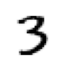

In [14]:
show_image(three_tensors[1]);

对于每个像素的位置，我们要计算该像素的强度在所有图像上的平均值。要做到这一点，我们首先将这个列表中的所有图像合并成一个单一的三维张量。描述这样一个张量的最常见的方式是将其称为等级3张量。我们经常需要将一个集合中的单个张量堆积成一个张量。不出所料，PyTorch自带了一个叫做stack的函数，我们可以用它来达到这个目的。

PyTorch中的一些操作，例如取平均值，需要我们将整数类型转换为浮点数类型。因为我们以后会需要这样做，所以我们现在也要把我们的堆栈张量转换为浮点数。在PyTorch中，投递的方法很简单，就是输入你想投递的类型的名称，并把它当作一个方法。

一般来说，当图像是浮点时，像素值应该在0和1之间，所以我们在这里也将除以255。

In [15]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

也许张量的最重要的属性是它的形状。这告诉你每个轴的长度。在这个例子中，我们可以看到我们有6,131张图片，每张图片的大小为28×28像素。这个张量并没有特别说明第一个轴是图像的数量，第二个是高度，第三个是宽度--张量的语义完全取决于我们，以及我们如何构建它。就PyTorch而言，它只是内存中的一堆数字。

张量的形状的长度就是它的等级。

In [16]:
len(stacked_threes.shape)

3

对你来说，记住并练习这些张量术语真的很重要：等级是张量中的轴或维数；形状是张量中每个轴的大小。

答：注意，因为 "维度 "这个术语有时有两种用法。考虑到我们生活在 "三维空间 "中，一个物理位置可以用一个3维向量v来描述。但是根据PyTorch，属性v.ndim（看起来肯定像v的 "维数"）等于1，而不是3！为什么？为什么呢？因为v是一个矢量，它是一个秩为1的张量，这意味着它只有一个轴（即使这个轴的长度为3）。换句话说，有时维度被用来表示一个轴的大小（"空间是三维的"）；其他时候，它被用来表示秩，或者轴的数量（"一个矩阵有两个维度"）。当感到困惑时，我发现将所有语句翻译成秩、轴和长度的术语是很有帮助的，这些术语是不明确的。

我们还可以用ndim直接获得张量的秩。

In [17]:
stacked_threes.ndim

3

最后，我们可以计算出理想的3是什么样子的。我们计算所有图像张量的平均值，方法是沿着我们的堆叠的第3级张量的0维取平均值。这是对所有图像进行索引的维度。

换句话说，对于每个像素的位置，这将计算出该像素在所有图像上的平均值。其结果将是每个像素位置的一个值，或一个单一的图像。这就是了。

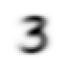

In [18]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

根据这个数据集，这是理想的3号! (你可能不喜欢它，但这就是3号的峰值表现。)你可以看到，在所有图像都认为它应该是黑暗的地方，它是非常黑暗的，但在图像不同意的地方，它变得飘忽不定，模糊不清。

让我们对7号做同样的事情，但把所有的步骤放在一起一次，以节省一些时间。

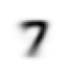

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

现在让我们挑选一个任意的3，测量它与我们的 "理想数字 "的距离。

停止：停下来思考！。你会如何计算一个特定的图像与我们每个理想数字的相似程度？记得离开这本书，在你继续前进之前记下一些想法! 研究表明，当你通过解决问题、做实验和自己尝试新的想法来参与学习过程时，记忆力和理解力都会有很大的提高

这里有一个样本3。

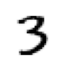

In [20]:
a_3 = stacked_threes[1]
show_image(a_3);

我们怎样才能确定它与我们的理想3的距离？我们不能只是把这个图像的像素和理想数字之间的差异加起来。有些差异会是正数，而有些则是负数，这些差异会被抵消，从而导致这样一种情况：一幅图像在某些地方太暗，而在其他地方太亮，可能会被显示为与理想数字的总差异为零。这将是一种误导!

为了避免这种情况，数据科学家在这种情况下有两种主要的测量距离的方法。

取差异的绝对值的平均值（绝对值是指用正值替换负值的函数）。这被称为平均绝对差异或L1准则
取差异的平方的平均值（这使得所有的东西都是正的），然后取平方根（这就取消了平方）。这就是所谓的均方根误差（RMSE）或L2准则。
重要的是：忘记了你的数学知识也没关系。在本书中，我们通常假设你已经完成了高中数学，并且至少记得其中的一些内容...... 但每个人都会忘记一些东西！这取决于你碰巧在什么时候忘记了。这完全取决于你在这段时间里有什么理由去练习。也许你已经忘记了什么是平方根，或者它们到底是如何工作的。没问题! 当你遇到一个在本书中没有完全解释的数学概念时，不要只是继续前进，而是要停下来查一查。确保你了解基本概念，它是如何工作的，以及为什么我们可能会使用它。刷新你的理解的最好地方之一是可汗学院。例如，可汗学院对平方根有一个很好的介绍。

现在让我们来试试这两个。

In [21]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

在这两种情况下，我们的3和 "理想 "的3之间的距离都小于与理想的7之间的距离。所以我们的简单模型在这种情况下会给出正确的预测。

PyTorch已经提供了这两个损失函数。你可以在torch.nn.functional中找到这些函数，PyTorch团队建议将其作为F导入（在fastai中默认以该名称提供）

In [23]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

这里mse代表平均平方误差，l1指的是平均绝对值的标准数学行话（在数学上称为L1规范）。

S: 直观地说，L1准则和平均平方误差（MSE）之间的区别是，后者会比前者更严重地惩罚大的错误（而对小的错误更宽容）。

J：当我第一次接触到 "L1 "这个东西时，我查了一下，看看它到底是什么意思。我在谷歌上发现，它是一个使用绝对值的向量规范，所以查了一下向量规范，开始阅读。给定一个实数或复数场F上的向量空间V，V上的规范是一个非负值的任意函数p。V→[0,+∞]，具有以下性质。对于所有a∈F和所有u，v∈V，p（u+v）≤p（u）+p（v）。然后我就不读了。"唉，我永远无法理解数学！" 我想，这已经是第一千次了。从那时起，我就知道，每当这些复杂的数学术语在实践中出现时，我都可以用一小段代码来代替它们！例如，L1损失只是一个小问题。比如，L1的损失只是等于(a-b).abs().mean()，其中a和b是张量。我想，懂数学的人只是和我的想法不同...... 我会在这本书中确保每当出现一些数学术语时，我也会给你提供它所等于的那一小段代码，并以常识性的术语解释发生了什么事。

我们刚刚完成了对PyTorch张量的各种数学运算。如果你以前在NumPy中做过一些数字编程，你可能会认出这些与NumPy数组相似。让我们来看看这两个非常重要的数据结构。


# 使用广播计算指标

回顾一下，度量是根据我们模型的预测和数据集中的正确标签计算出来的一个数字，以便告诉我们我们的模型有多好。例如，我们可以使用我们在上一节中看到的任何一个函数，平均平方误差，或平均绝对误差，并在整个数据集上取其平均值。然而，这两个数字对大多数人来说都不太容易理解；在实践中，我们通常使用准确性作为分类模型的衡量标准。

正如我们所讨论的，我们要在一个验证集上计算我们的度量。这是为了避免我们无意中过度拟合--也就是说，训练一个模型只在我们的训练数据上运行良好。对于我们在这里作为第一次尝试使用的像素相似度模型来说，这并不是一个真正的风险，因为它没有训练过的成分，但是我们还是要使用一个验证集来遵循正常的做法，并为以后的第二次尝试做准备。

为了得到一个验证集，我们需要从训练中完全删除一些数据，所以它根本就不会被模型看到。事实证明，MNIST数据集的创建者已经为我们做了这些。你还记得有一个叫valid的独立目录吗？这就是这个目录的作用!

In [24]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

养成边走边检查形状的习惯是件好事。这里我们看到了两个张量，一个代表由1,010张28×28大小的图像组成的3S验证集，另一个代表由1,028张28×28大小的图像组成的7S验证集。

我们最终想写一个函数，is_3，它将决定一个任意图像是3还是7，它将通过决定这个任意图像更接近我们的两个 "理想数字 "来实现。为此，我们需要定义一个距离的概念，也就是一个计算两个图像之间距离的函数。

我们可以写一个简单的函数来计算平均绝对误差，使用的表达式与我们在上一节写的非常相似。

In [25]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

这与我们之前计算的这两幅图像的距离是一样的，理想3的平均值3和任意样本3的a_3，它们都是形状为[28,28]的单图像张量。

但是为了计算整体准确性的度量，我们需要计算验证集中每张图像与理想3的距离。我们如何进行这一计算呢？我们可以在我们的验证集张量，valid_3_tens，即形状为[1010,28,28]代表1,010张图像的所有单图像张量上写一个循环。但是有一个更好的方法。

当我们使用这个完全相同的距离函数时，会发生一些非常有趣的事情，这个函数是为比较两幅单一的图像而设计的，但作为一个参数传入valid_3_tens，即代表3s验证集的张量。

In [26]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1423, 0.1137, 0.1228,  ..., 0.1493, 0.1169, 0.1230]),
 torch.Size([1010]))

它没有抱怨形状不匹配，而是将每张图片的距离作为一个长度为1,010（我们的验证集中3的数量）的向量（即等级1张量）返回。这是怎么发生的呢？

再看一下我们的函数mnist_distance，你会发现我们在那里做了减法（a-b）。神奇的是，当PyTorch试图在两个不同等级的张量之间进行简单的减法操作时，会使用广播。也就是说，它将自动扩展具有较小等级的张量，使其具有与具有较大等级的张量相同的大小。广播是一种重要的能力，它使张量代码更容易编写。

在广播使两个参数张量具有相同的等级后，PyTorch对两个具有相同等级的张量应用其通常的逻辑：它对两个张量的每个对应元素执行操作，并返回张量结果。比如说。

In [27]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

因此，在这种情况下，PyTorch将代表单一图像的第2级张量mean3视为同一图像的1,010份副本，然后从验证集中的每个3中减去这些副本。你认为这个张量会有什么形状？在你看下面的答案之前，试着自己想一想。

In [28]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

关于广播的实现方式有几个要点，这使得它不仅在表现力方面有价值，在性能方面也有价值。

PyTorch实际上并没有复制mean3 1,010次。它假装自己是那种形状的张量，但实际上并没有分配任何额外的内存
它用C语言（或者，如果你使用的是GPU，用CUDA，相当于GPU上的C语言）完成整个计算，比纯Python快几万倍（在GPU上可快达数百万倍！）。
在PyTorch中进行的所有广播和元素操作和函数都是如此。这是创建高效的PyTorch代码所需了解的最重要的技术。

接下来在mnist_distance中我们看到了abs。你现在可能已经能够猜到，当应用于张量时，它的作用是什么。它将方法应用于张量中的每个元素，并返回结果的张量（也就是说，它 "按元素 "应用方法）。所以在这种情况下，我们将得到1010个绝对值的矩阵。

最后，我们的函数调用mean((-1,-2))。元组(-1,-2)代表一个轴的范围。在Python中，-1指的是最后一个元素，而-2指的是倒数第二的元素。所以在这种情况下，这告诉PyTorch我们要取的是张量的最后两个轴所索引的数值的平均值。最后两个轴是图像的水平和垂直尺寸。在取完最后两个轴的平均值后，我们只剩下第一个张量轴，它索引了我们的图像，这就是为什么我们最终的大小是（1010）。换句话说，对于每一幅图像，我们对该图像中所有像素的强度进行了平均。

在本书中，我们会学到更多关于广播的知识，特别是在<>中，也会经常练习它。

我们可以使用mnist_distance来计算一幅图像是否为3，其逻辑如下：如果有关数字与理想的3之间的距离小于与理想的7之间的距离，那么它就是3。 这个函数将自动进行广播，并按元素应用，就像所有PyTorch函数和运算符一样。

In [29]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [30]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [31]:
is_3(valid_3_tens)

tensor([ True,  True, False,  ...,  True,  True,  True])

In [32]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

这看起来是一个相当好的开始！我们在3分和7分上的准确率都超过了90%。我们在3和7上的准确率都超过了90%，而且我们已经看到了如何使用广播来方便地定义一个指标。

但是，让我们说实话：3和7是看起来非常不同的数字。而且到目前为止，我们只对10个可能的数字中的两个进行了分类。所以我们需要做得更好!

为了做得更好，也许现在是时候尝试一个能够进行真正学习的系统了--也就是说，它能够自动修改自己以提高其性能。换句话说，现在是时候谈谈训练过程和SGD了。

# Stochastic Gradient Descent (SGD)

你还记得我们在<>中引用的Arthur Samuel描述机器学习的方式吗？

: 假设我们安排了一些自动手段来测试任何当前权重分配在实际性能方面的有效性，并提供一种机制来改变权重分配，以使性能最大化。我们不需要研究这种程序的细节，就可以看到它可以完全自动进行，并且看到这样编程的机器会从其经验中 "学习"。

正如我们所讨论的，这是允许我们拥有一个可以变得越来越好的模型的关键--它可以学习。但我们的像素相似度方法并没有真正做到这一点。我们没有任何类型的权重分配，也没有任何基于测试权重分配有效性的改进方法。换句话说，我们不能通过修改一组参数来真正改善我们的像素相似性方法。为了利用深度学习的力量，我们首先要以阿瑟-塞缪尔描述的方式来表示我们的任务。

我们可以不试图寻找图像和 "理想图像 "之间的相似性，而是观察每个单独的像素，并为每个像素制定一套权重，这样，最高的权重与那些最可能是黑色的特定类别的像素相关。例如，右下角的像素不太可能被激活为7，所以它们对7的权重应该很低，但它们很可能被激活为8，所以它们对8的权重应该很高。这可以表示为一个函数和每个可能类别的权重值集合--例如成为数字8的概率。

def pr_eight(x,w): return (x*w).sum()
这里我们假设x是图像，以向量的形式表示--换句话说，所有的行都堆积在一起，成为一个长线。如果我们有了这个函数，那么我们只需要用一些方法来更新权重，使它们变得更好一些。有了这样的方法，我们可以多次重复这个步骤，使权重越来越好，直到它们达到我们所能做到的最佳状态。

我们想找到矢量w的具体数值，使我们的函数的结果对那些实际上是8的图像来说是高的，而对那些不是8的图像来说是低的。寻找最佳向量w是寻找识别8的最佳函数的一种方法。（因为我们还没有使用深度神经网络，所以我们的函数实际能做的事情是有限的--我们将在本章后面解决这个限制）。

更具体地说，以下是我们将需要的步骤，以把这个函数变成一个机器学习分类器。

初始化权重。

对于每张图片，使用这些权重来预测它是3还是7。

基于这些预测，计算模型的好坏（其损失）。

计算梯度，即衡量每个权重的梯度，改变该权重将如何改变损失。

根据这一计算，对所有的权重进行调整（也就是改变）。

回到第2步，重复这个过程。

反复进行，直到你决定停止训练过程（例如，因为模型已经足够好或者你不想再等了）。

这七个步骤，在<>中说明，是所有深度学习模型训练的关键。深度学习原来完全依赖这些步骤，这是非常令人惊讶和反直觉的。这个过程能够解决如此复杂的问题，真是令人惊讶。但是，正如你将看到的那样，它真的做到了!

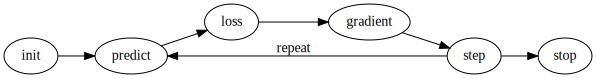

In [33]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [34]:
??gv

这七个步骤中的每一个都有许多不同的方法，我们将在本书的其余部分中学习这些方法。这些都是对深度学习从业者有很大影响的细节，但事实证明，每个人的一般做法一般都遵循一些基本原则。以下是一些准则。

初始化：。我们将参数初始化为随机值。这听起来可能令人惊讶。当然，我们还可以做出其他选择，例如将它们初始化为该像素在该类别中被激活的百分比--但由于我们已经知道我们有一个例行程序来改进这些权重，事实证明，只是从随机权重开始，效果非常好。

损失:: 这就是塞缪尔在谈到测试任何当前权重分配在实际性能方面的有效性时所提到的。我们需要一些函数来返回一个数字，如果模型的性能很好，这个数字就会很小（标准的做法是把小的损失当作好的，大的损失当作坏的，虽然这只是一个惯例）。

步骤：。一个简单的方法来弄清楚一个权重是否应该增加一点，或者减少一点，那就是直接试一试：增加少量的权重，看看损失是上升还是下降。一旦你找到了正确的方向，你就可以把这个量多改一点，少改一点，直到你找到一个效果好的量。然而，这样做很慢! 正如我们将看到的，微积分的魔力使我们能够直接计算出在哪个方向，以及大致多少，来改变每个重量，而不必尝试所有这些小的变化。做到这一点的方法是计算梯度。这只是一个性能优化，我们通过使用较慢的手动过程也会得到完全相同的结果。

停止：。一旦我们决定对模型进行多少次训练（在前面的列表中给出了一些这方面的建议），我们就应用这个决定。这就是应用该决定的地方。对于我们的数字分类器，我们会一直训练，直到模型的准确性开始变差，或者我们的时间耗尽。

在将这些步骤应用于我们的图像分类问题之前，让我们来说明一下它们在更简单的情况下是什么样子。首先，我们将定义一个非常简单的函数，即二次函数--让我们假设这是我们的损失函数，而x是该函数的一个权重参数。



In [35]:
def f(x): return x**2

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


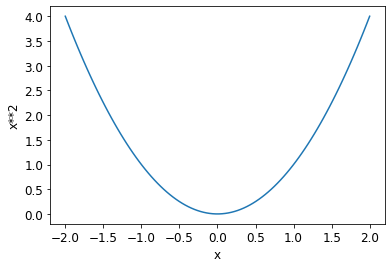

In [36]:
plot_function(f, 'x', 'x**2')

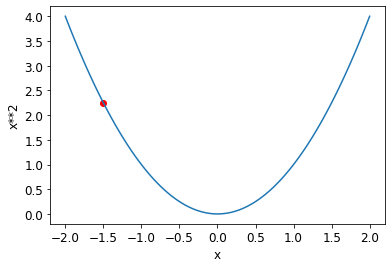

In [37]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

这一基本思想可以一直追溯到艾萨克-牛顿，他指出我们可以用这种方式优化任意函数。无论我们的函数变得多么复杂，梯度下降的这种基本方法都不会有明显变化。我们在本书后面将看到的唯一的小变化是一些方便的方法，我们可以通过找到更好的步骤来使它更快。

# Calculating Gradients

一个神奇的步骤是我们计算梯度的部分。正如我们提到的，我们使用微积分作为性能优化；它允许我们更快速地计算当我们向上或向下调整参数时，我们的损失是上升还是下降。换句话说，梯度将告诉我们，我们必须改变每个权重多少才能使我们的模型更好。

你可能还记得在高中微积分课上，一个函数的导数告诉你其参数的变化会对其结果产生多大的影响。如果没有，不要担心，一旦高中毕业，我们很多人都会忘记微积分！但是，你必须有一些直觉。但是，在你继续学习之前，你必须对什么是导数有一些直观的了解，所以如果你的脑子里这些东西都很模糊，请到可汗学院去，完成基本导数的课程。你不需要自己知道如何计算，你只需要知道什么是导数。

关于导数的关键点是：对于任何函数，例如我们在上一节看到的二次函数，我们可以计算其导数。导数是另一个函数。它计算的是变化，而不是值。例如，二次函数在值3处的导数告诉我们函数在值3处的变化有多快。更具体地说，你可能记得，梯度被定义为上升/下降，也就是说，函数值的变化除以参数值的变化。当我们知道我们的函数将如何变化，那么我们就知道我们需要做什么来使它变小。这就是机器学习的关键：有办法改变一个函数的参数，使其变小。微积分为我们提供了一个计算上的捷径，即导数，它可以让我们直接计算出我们函数的梯度。

需要注意的一件事是，我们的函数有很多需要调整的权重，所以当我们计算导数时，我们得到的不是一个数字，而是很多个数字--每个权重的梯度。但这里没有什么数学上的困难；你可以计算一个权重的导数，并将其他所有的权重视为常数，然后对其他每个权重重复计算。这就是所有梯度的计算方法，对每个权重都是如此。

我们刚才提到，你不需要自己计算任何梯度。这怎么可能呢？令人惊讶的是，PyTorch能够自动计算几乎所有函数的导数！而且，它还能自动计算。更重要的是，它的计算速度非常快。大多数时候，它的速度至少和你手工创建的任何导数函数一样快。让我们看一个例子。

首先，让我们选择一个我们想要的梯度的张量值。

In [38]:
xt = tensor(3.).requires_grad_()

注意到这个特殊的方法 requires_grad_了吗？这是一个神奇的咒语，我们用它来告诉PyTorch，我们要计算与该变量有关的梯度值。它本质上是对变量进行标记，所以PyTorch会记住如何计算其他的梯度，直接计算你所要求的。

a: 如果你来自数学或物理学，这个API可能会让你感到困惑。在这些背景下，一个函数的 "梯度 "只是另一个函数（即它的导数），所以你可能期望梯度相关的API会给你一个新的函数。但在深度学习中，"梯度 "通常是指一个函数在特定参数值下的导数值。PyTorch API还将重点放在参数上，而不是你实际计算梯度的函数。一开始可能会觉得很反感，但这只是一个不同的视角而已。

现在我们用这个值来计算我们的函数。注意到PyTorch不仅打印了计算的值，而且还注意到它有一个梯度函数，在需要的时候它将用来计算我们的梯度。

In [39]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

最后，我们告诉PyTorch为我们计算梯度。

In [40]:
yt.backward()


这里的 "向后 "指的是反向传播，这是计算每一层的导数的过程的名称。我们将在<>章中看到这到底是怎么做的，当我们从头开始计算一个深度神经网络的梯度。这被称为网络的 "backward pass"，而不是 "forward pass"，后者是计算激活的地方。如果后向被称为calculate_grad，生活可能会更简单，但深度学习的人真的喜欢在任何地方添加行话( jargon )。

我们现在可以通过检查我们张量的grad属性来查看梯度。

In [41]:
xt.grad

tensor(6.)

如果你还记得你的高中微积分规则，x**2的导数是2*x，而我们有x=3，所以梯度应该是2*3=6，这也是PyTorch为我们计算的结果

现在我们将重复前面的步骤，但要为我们的函数添加一个矢量参数。

In [42]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

我们将把sum添加到我们的函数中，这样它就可以接受一个向量（即一个秩1张量），并返回一个标量（即一个秩0张量）。

In [43]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are 2*xt, as we'd expect!

In [44]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

梯度只告诉我们函数的斜率，它们实际上并不告诉我们究竟要调整参数到什么程度。但它给我们提供了一些概念；如果斜率非常大，那么这可能表明我们有更多的调整要做，而如果斜率非常小，这可能表明我们已经接近了最佳值。

# Stepping With a Learning Rate

决定如何根据梯度值来改变我们的参数是深度学习过程中的一个重要部分。几乎所有的方法都是从梯度乘以某个小数字（称为学习率( learning rate)（LR））的基本想法开始的。学习率通常是一个介于0.001和0.1之间的数字，尽管它可以是任何东西。通常情况下，人们选择学习率时，只需尝试几个，然后找出训练后的最佳模型（我们将在本书后面告诉你一个更好的方法，称为学习率查找器）。一旦你选择了一个学习率，你就可以用这个简单的函数调整你的参数。

w -= gradient(w) * lr

这就是所谓的步进参数，使用优化器(optimizer) 步骤。

如果你选择了一个太低的学习率，这可能意味着必须做很多步骤。<>说明了这一点。

但是选择一个过高的学习率就更糟糕了--它实际上会导致损失越来越严重，就像我们在<>中看到的那样!

如果学习率太高，它也可能会 "反弹"，而不是真正的发散；<>显示了这种情况的结果是需要很多步骤才能训练成功。

Now let's apply all of this in an end-to-end example.

# An End-to-End SGD Example

In [45]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

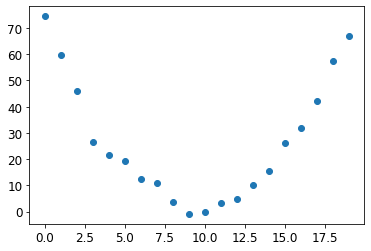

In [46]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

我们加入了一些随机噪音，因为手动测量的东西并不精确。这意味着要回答这个问题并不那么容易：过山车的速度是多少？使用SGD，我们可以尝试找到一个与我们的观察结果相匹配的函数。我们不能考虑每一个可能的函数，所以让我们用一个猜测，它将是二次函数；也就是说，一个形式为a*(time**2)+(b*time)+c的函数。

我们要明确区分函数的输入（我们测量过山车速度的时间）和它的参数（定义我们要尝试的二次方的值）。因此，让我们把参数收集在一个参数中，从而在函数的签名中把输入（t）和参数（params）分开。

In [47]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

换句话说，我们把寻找可以想象到的适合数据的最佳函数的问题，限制为寻找最佳二次函数。这大大简化了问题，因为每个二次函数都完全由三个参数a、b和c定义。因此，要找到最佳二次函数，我们只需要找到a、b和c的最佳值。

如果我们能解决二次函数的三个参数的问题，我们就能对其他更复杂的、有更多参数的函数--如神经网--应用同样的方法。让我们先找到f的参数，然后我们再回来用神经网络对MNIST数据集做同样的事情。

我们首先需要定义我们所说的 "最佳 "是什么意思。我们通过选择一个损失函数来精确定义，该函数将根据预测和目标返回一个值，该函数的低值对应于 "更好 "的预测。对于连续数据，通常使用平均平方误差。

In [48]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

# 现在，让我们通过我们的7个步骤进行工作。

第1步：初始化参数
首先，我们将参数初始化为随机值，并使用require_grad_告诉PyTorch，我们要跟踪它们的梯度。

In [49]:
params = torch.randn(3).requires_grad_()

In [50]:
#hide
orig_params = params.clone()

第2步：计算预测值
接下来，我们计算预测结果。

In [51]:
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [52]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

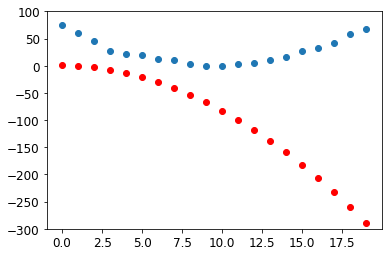

In [53]:
show_preds(preds)

这看起来不是很接近--我们的随机参数表明，过山车最终会倒退，因为我们的速度是负的！"。

第三步：计算损失

我们计算损失的方法如下。

In [54]:
loss = mse(preds, speed)
loss

tensor(160.6979, grad_fn=<SqrtBackward0>)

我们现在的目标是改进这一点。要做到这一点，我们需要知道梯度。

第4步：计算梯度

下一步是计算梯度。换句话说，计算出参数需要如何变化的近似值。

In [55]:
loss.backward()
params.grad

tensor([-165.5151,  -10.6402,   -0.7900])

In [56]:
params.grad * 1e-5

tensor([-1.6552e-03, -1.0640e-04, -7.8996e-06])

我们可以使用这些梯度来改善我们的参数。我们需要选择一个学习率（我们将在下一章讨论如何在实践中做到这一点；现在我们只使用1e-5，或0.00001）。

In [57]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

第5步：加权。
现在我们需要根据刚才计算的梯度来更新参数。

In [58]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

a: 理解这个位子取决于对近期历史的记忆。为了计算梯度，我们在损失上向后调用。但是这个损失本身是由mse计算的，而mse又把preds作为输入，而preds是用f计算的，把params作为输入，而params是我们最初调用required_grads_的对象--这就是最初的调用，现在我们可以向后调用损失。这一连串的函数调用代表了函数的数学组成，这使得PyTorch能够在引擎盖下使用微积分的连锁规则来计算这些梯度。

让我们看看损失是否得到了改善。


In [59]:
preds = f(time,params)
mse(preds, speed)

tensor(160.4228, grad_fn=<SqrtBackward0>)

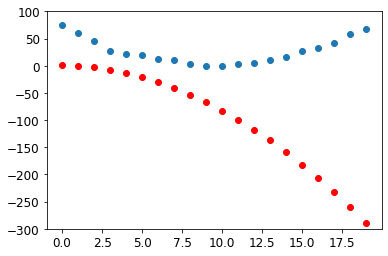

In [60]:
show_preds(preds)

我们需要重复几次，所以我们将创建一个函数来应用一个步骤。

In [61]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

第6步：重复这个过程

现在我们进行迭代。通过循环并进行多次改进，我们希望能达到一个好的结果。

In [62]:
for i in range(10): apply_step(params)

160.42279052734375
160.14772033691406
159.87269592285156
159.59768676757812
159.3227081298828
159.04774475097656
158.7728271484375
158.4979248046875
158.22305297851562
157.9481964111328


In [63]:
#hide
params = orig_params.detach().requires_grad_()

损失正在减少，正如我们所希望的那样！但只看这些损失数字掩盖了这样一个事实：在寻找最佳二次函数的过程中，每一次迭代都代表了一个完全不同的二次函数。但只看这些损失数字掩盖了这样一个事实：在寻找最佳二次函数的过程中，每一次迭代都代表了一个完全不同的二次函数被尝试。我们可以直观地看到这个过程，如果我们不打印出损失函数，而是绘制每一步的函数。然后我们就可以看到形状是如何接近我们数据的最佳二次函数的。

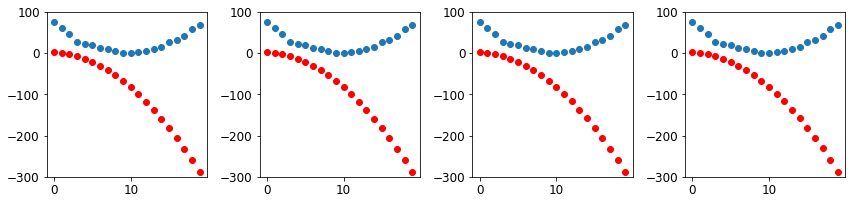

In [64]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

第7步：停止

我们刚刚决定在10个 epochs之后任意停止。在实践中，我们会观察训练和验证的损失以及我们的指标来决定何时停止，正如我们已经讨论过的。

# Summarizing Gradient Descent

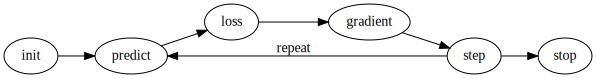

In [65]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

总结一下，在开始的时候，我们模型的权重可以是随机的（从头开始训练），也可以来自预训练的模型（转移学习）。在第一种情况下，我们从输入中得到的输出与我们想要的没有任何关系，甚至在第二种情况下，预训练的模型很可能在我们所针对的具体任务上不是很好。因此，该模型需要学习更好的权重。

我们首先用损失函数比较模型给我们的输出和我们的目标（我们有标记的数据，所以我们知道模型应该给出什么结果），损失函数返回一个数字，我们希望通过提高权重使之尽可能低。要做到这一点，我们从训练集中抽取一些数据项（如图像），并将其输入我们的模型。我们使用损失函数比较相应的目标，得到的分数告诉我们我们的预测有多错。然后我们稍微改变一下权重，使之稍微好一点。

为了找到如何改变权重以使损失好一点，我们用微积分来计算梯度。(实际上，我们让PyTorch为我们做这件事！）让我们考虑一个比喻。想象一下，你在山上迷路了，你的车停在最低点。为了找到回去的路，你可能会在一个随机的方向徘徊，但这可能没有什么帮助。既然你知道你的车在最低点，你最好还是下山。始终向最陡峭的下坡方向迈出一步，你应该最终到达目的地。我们使用坡度的大小（即坡度的陡峭程度）来告诉我们要走多大的一步；具体来说，我们用坡度乘以我们选择的一个数字，即学习率，来决定步幅大小。然后我们进行迭代，直到我们达到最低点，也就是我们的停车场，然后我们就可以停止了。

我们刚才看到的所有内容都可以直接移植到MNIST数据集上，除了损失函数。现在让我们看看我们如何定义一个好的训练目标。

MNIST损失函数

我们已经有了我们的自变量x--这些是图像本身。我们将把它们串联成一个张量，并把它们从一个矩阵列表（等级3的张量）变为一个向量列表（等级2的张量）。我们可以用view来做这件事，view是PyTorch的一个方法，可以改变张量的形状而不改变其内容。-1是view的一个特殊参数，意味着 "使这个轴尽可能大，以适应所有的数据"。

In [66]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We'll use 1 for 3s and 0 for 7s:



In [67]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

PyTorch中的数据集在被索引时需要返回一个(x,y)的元组。Python提供了一个zip函数，当它与list结合时，提供了一个简单的方法来获得这个功能。

In [68]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [69]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [70]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [71]:
weights = init_params((28*28,1))

函数weights*pixels将不够灵活--当像素等于0时，它总是等于0（即其截距为0）。你可能还记得高中时的数学，直线的公式是y=w*x+b；我们仍然需要b，我们也要把它初始化为一个随机数。


In [72]:
bias = init_params(1)

在神经网络中，方程y=w*x+b中的w被称为权重，b被称为偏置。权重和偏置共同构成了参数。

行话。参数。一个模型的权重和偏差。权重是方程w*x+b中的w，而偏差是该方程中的b。

现在我们可以计算出一幅图像的预测结果。

In [73]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

虽然我们可以使用Python的for循环来计算每张图片的预测值，但那会非常慢。因为Python循环不能在GPU上运行，而且一般来说Python是一种缓慢的循环语言，所以我们需要在一个模型中尽可能多地使用高级函数来表示计算。

在这种情况下，有一个极其方便的数学运算，可以计算矩阵每一行的w*x--这就是所谓的矩阵乘法。<>显示了矩阵乘法的样子。

在Python中，矩阵乘法是用@运算符表示的。让我们来试试。

In [74]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

第一个元素与我们之前计算的相同，正如我们所期望的那样。这个方程，batch@weights + bias，是任何神经网络的两个基本方程之一（另一个是激活函数，我们稍后会看到）。

让我们检查一下我们的准确性。要决定一个输出是否代表3或7，我们只需检查它是否大于0.5，所以我们对每个项目的准确性可以用以下方法计算（使用广播，所以没有循环！）。

In [75]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [76]:
corrects.float().mean().item()

0.49080348014831543

现在让我们看看其中一个权重的微小变化会带来怎样的精度变化。

In [77]:
#with torch.no_grad():
  #weights[0]= 1.0001*weights[0]

In [78]:
#weights.requires_grad=True

In [79]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

正如我们所看到的，我们需要梯度，以便使用SGD改进我们的模型，而为了计算梯度，我们需要一些损失函数来代表我们的模型有多好。这是因为梯度是衡量损失函数随着权重的小幅调整而变化的一个尺度。

因此，我们需要选择一个损失函数。明显的方法是使用准确性，也就是我们的指标，作为我们的损失函数。在这种情况下，我们将计算每张图片的预测值，收集这些值来计算总体准确度，然后计算每个权重相对于总体准确度的梯度。

不幸的是，我们在这里有一个重要的技术问题。一个函数的梯度是它的斜率，或者说它的陡度，可以定义为上升大于下降--也就是说，函数的值上升或下降多少，除以我们改变输入多少。我们可以在数学上将其写成。(y_new - y_old) / (x_new - x_old) 。当x_new与x_old非常相似时，这给了我们一个很好的梯度近似值，也就是说，它们的差异非常小。但是，只有当预测值从3变成7，或反之亦然时，准确性才会发生根本性的变化。问题是，权重从x_old到x_new的微小变化不可能导致任何预测的变化，所以（y_new-y_old）几乎总是0。 换句话说，梯度几乎在任何地方都是0。

权重值的一个非常小的变化往往不会实际改变准确度。这意味着使用精度作为损失函数是没有用的--如果我们这样做，大多数时候我们的梯度实际上是0，而模型将无法从这个数字中学习。

S: 在数学上，准确度是一个几乎在任何地方都是常数的函数（除了阈值，0.5），所以它的导数几乎在任何地方都是零（在阈值处是无穷大）。这样一来，梯度就变成了0或无穷大，这对更新模型是没有用的。

相反，我们需要一个损失函数，当我们的权重导致稍微好一点的预测时，给我们一个稍微好一点的损失。那么，"稍好的预测 "到底是什么样子的呢？好吧，在这种情况下，它意味着如果正确答案是3，分数就会高一点，或者如果正确答案是7，分数就会低一点。

我们现在来写一个这样的函数。它的形式是什么？

损失函数接收的不是图像本身，而是来自模型的预测值。让我们做一个参数，prds，其值在0和1之间，每个值都是一个图像是3的预测值，它是一个向量（即等级1张量），在图像上索引。

损失函数的目的是测量预测值和真实值之间的差异，也就是目标（又称标签）。让我们做另一个参数，trgts，其值为0或1，告诉人们一个图像实际上是否是3。它也是一个向量（即另一个秩1张量），在图像上索引。

例如，假设我们有三张图片，我们知道它们分别是3、7和3。假设我们的模型以高置信度（0.9）预测第一张是3，以小置信度（0.4）预测第二张是7，以一般置信度（0.2）预测最后一张是7，但不正确。

In [80]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

下面是对衡量预测和目标之间距离的损失函数的首次尝试。

In [81]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

我们正在使用一个新的函数，torch.where(a,b,c)。这与运行列表理解[b[i] if a[i] else c[i] for i in range(len(a))]是一样的，只是它以C/CUDA的速度在张量上工作。简单地说，这个函数将测量每个预测值与1的距离（如果它应该是1），以及它与0的距离（如果它应该是0），然后它将取所有这些距离的平均值。

注意：阅读文档。了解像这样的PyTorch函数是很重要的，因为在Python中对张量的循环是以Python的速度执行的，而不是C/CUDA的速度! 现在试着运行help(torch.where)来阅读这个函数的文档，或者更好的是，在PyTorch文档网站上查找它。

让我们在我们的prds和trgts上试试吧。

In [82]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

你可以看到，当预测更准确时，这个函数会返回一个较低的数字，当准确的预测更有信心时（绝对值较高），而当不准确的预测更没有信心时。在PyTorch中，我们总是假设损失函数的值越低越好。由于我们需要一个标量来表示最终的损失，所以mnist_loss取的是之前张量的平均值。

In [83]:
mnist_loss(prds,trgts)

tensor(0.4333)

例如，如果我们把对一个 "错误 "目标的预测从0.2改为0.8，损失就会下降，表明这是一个更好的预测。

In [84]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

目前定义的mnist_loss的一个问题是，它假定预测值总是在0和1之间，那么，我们需要确保实际情况是这样的! 碰巧的是，有一个函数正是这样做的--我们来看看。


Sigmoid

sigmoid函数总是输出一个介于0和1之间的数字，它的定义如下。

In [85]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Pytorch为我们定义了一个加速版本，所以我们并不真的需要自己的版本。这是深度学习中的一个重要功能，因为我们经常想确保数值在0和1之间。

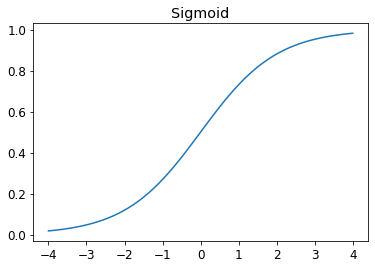

In [86]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

正如你所看到的，它接受任何输入值，不管是正的还是负的，并把它塞到0和1之间的输出值上。它也是一条只向上的平滑曲线，这使SGD更容易找到有意义的梯度。

让我们更新mnist_loss，首先将sigmoid应用于输入。

In [87]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

在定义了损失函数之后，现在是一个很好的时机来回顾一下我们为什么这样做。毕竟，我们已经有了一个衡量标准，那就是总体准确性。那么，我们为什么要定义一个损失呢？

关键的区别在于，指标是用来驱动人类理解的，而损失是用来驱动自动学习的。为了推动自动学习，损失必须是一个有意义的导数的函数。它不能有大的平坦部分和大的跳跃，而必须是相当平滑的。这就是为什么我们设计了一个能对信心水平的微小变化做出反应的损失函数。这个要求意味着，有时它并不能真正准确反映我们要实现的目标，而是在我们真正的目标和一个可以使用其梯度进行优化的函数之间的折中。损失函数是为我们的数据集中的每一个项目计算的，然后在一个历时结束时，损失值被全部平均化，并报告该历时的总平均值。

另一方面，指标是我们真正关心的数字。这些是在每个历时结束时打印出来的数值，告诉我们模型的真实表现。重要的是，我们要学会在判断一个模型的性能时，关注这些指标，而不是损失。

SGD and Mini-Batches

现在我们有了一个适合驱动SGD的损失函数，我们可以考虑学习过程的下一阶段所涉及的一些细节，即根据梯度改变或更新权重。这被称为优化步骤。

为了采取优化步骤，我们需要计算一个或多个数据项的损失。我们应该使用多少个？我们可以对整个数据集进行计算，然后取其平均值，或者我们可以对单个数据项进行计算。但这两种方法都不理想。对整个数据集进行计算会花费很长的时间。对单个项目进行计算不会使用很多信息，所以会导致一个非常不精确和不稳定的梯度。也就是说，你会费尽心思去更新权重，但只考虑到如何提高模型在那个单一项目上的表现。

因此，我们在这两者之间采取了一个折衷办法：我们一次计算几个数据项的平均损失。这被称为 "迷你批"。迷你批次中的数据项的数量被称为批次大小。较大的批处理量意味着你将从损失函数中获得对数据集梯度的更准确和稳定的估计，但它将花费更长的时间，你将在每个历时中处理较少的迷你批。选择一个好的批次大小是你作为一个深度学习从业者需要做出的决定之一，以快速而准确地训练你的模型。我们将在本书中讨论如何做出这个选择。

使用迷你批次而不是在单个数据项上计算梯度的另一个很好的理由是，在实践中，我们几乎总是在GPU等加速器上进行训练。这些加速器只有在一次有大量工作要做的情况下才会有好的表现，所以如果我们能给它们大量的数据项来工作，就会有帮助。使用迷你批处理是做到这一点的最好方法之一。然而，如果你一次给它们太多的数据，它们就会耗尽内存，让GPU感到高兴也是很棘手的。

正如我们在讨论<>中的数据增强时看到的那样，如果我们能在训练期间改变一些东西，就能获得更好的泛化效果。我们可以改变的一个简单而有效的事情是我们在每个小批次中放入哪些数据项目。我们通常做的不是简单地按顺序列举我们的数据集，而是在创建迷你批之前，在每个历时中随机洗牌。PyTorch和fastai提供了一个类，它将为你做洗牌和迷你批的整理工作，称为DataLoader。

DataLoader可以接受任何Python集合，并把它变成许多批次的迭代器，就像这样。

In [88]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

为了训练一个模型，我们不仅仅需要任何Python集合，而是一个包含自变量和因变量（也就是模型的输入和目标）的集合。在PyTorch中，一个包含自变量和因变量图元的集合被称为数据集。下面是一个极其简单的Dataset的例子。

In [89]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

当我们把一个数据集传递给DataLoader时，我们会得到许多批次，这些批次本身就是代表自变量和因变量批次的张量的图例。

In [94]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

现在，我们已经准备好为使用SGD的模型编写我们的第一个训练循环了!

Putting It All Together

首先，让我们重新初始化我们的参数。

In [88]:
weights = init_params((28*28,1))
bias = init_params(1)

一个DataLoader可以从一个数据集创建

In [95]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

我们将对验证集做同样的处理。

In [96]:
valid_dl = DataLoader(valid_dset, batch_size=256)

让我们创建一个大小为4的mini-batch进行测试。

In [97]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [98]:
preds = linear1(batch)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        [10.7147]], grad_fn=<AddBackward0>)

In [99]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(5.6028e-06, grad_fn=<MeanBackward0>)

现在我们可以计算梯度了。

In [100]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-9.8339e-07), tensor([-5.6027e-06]))

让我们把这些都放在一个函数中。

In [101]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

并测试它。

In [102]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-1.9668e-06), tensor([-1.1205e-05]))

但看看如果我们调用两次会发生什么。

In [103]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-2.9502e-06), tensor([-1.6808e-05]))

梯度已经改变了! 原因是 loss.backward 实际上是将 loss 的梯度加到当前存储的任何梯度上。所以，我们必须先将当前梯度设置为0。

In [104]:
weights.grad.zero_()
bias.grad.zero_();

注：就地操作。PyTorch中名称以下划线结尾的方法会原地修改其对象。例如，bias.zero_()将张量bias的所有元素设置为0。

我们唯一剩下的步骤是根据梯度和学习率来更新权重和偏置。当我们这样做时，我们必须告诉PyTorch不要取这一步的梯度--否则，当我们试图在下一批计算导数时，事情会变得非常混乱! 如果我们给张量的数据属性赋值，那么PyTorch就不会采取这一步的梯度。下面是我们一个epoch的基本训练循环。

In [105]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

我们还想通过查看验证集的准确性来检查我们做得如何。为了决定一个输出是否代表3或7，我们可以只检查它是否大于0。

In [106]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

这给了我们这个函数来计算我们的验证准确性。

In [107]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

我们可以检查它是否有效。

In [108]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

然后把各批次的产品放在一起。

In [109]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [110]:
validate_epoch(linear1)

0.4917

这就是我们的起点。让我们训练一个历时，看看准确性是否提高。

In [111]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4927

然后再做几个。

In [112]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.4922 0.4927 0.4927 0.4927 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 

看上去不错! 我们已经达到了与我们的 "像素相似性 "方法相同的精度，而且我们已经创建了一个可以建立的通用基础。我们的下一步将是创建一个对象，为我们处理SGD步骤。在PyTorch中，它被称为优化器。

# Creating an Optimizer

由于这是一个非常普遍的基础，PyTorch提供了一些有用的类来使其更容易实现。我们可以做的第一件事是用PyTorch的nn.Linear模块取代我们的linear1函数。模块是一个继承自PyTorch nn.Module类的对象。这个类的对象的行为与标准的Python函数相同，你可以用括号来调用它们，它们将返回一个模型的激活。

nn.Linear与我们的init_params和linear一起做同样的事情。它在一个单一的类中同时包含了权重和偏差。下面是我们如何复制上一节中的模型。


In [114]:
linear_model = nn.Linear(28*28,1)

每个PyTorch模块都知道它有哪些可以训练的参数；它们可以通过parameter方法获得。

In [115]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

我们可以使用这些信息来创建一个优化器。

In [117]:
class BasicOptim:
    def __init__(self,params,lr): 
      self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: 
          p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
          p.grad = None

我们可以通过传入模型的参数来创建我们的优化器。

In [118]:
opt = BasicOptim(linear_model.parameters(), lr)

我们的训练循环现在可以简化为。

In [119]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

我们的验证功能根本不需要改变。

In [120]:
validate_epoch(linear_model)

0.4991

In [121]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

其结果与上一节相同。

In [122]:
train_model(linear_model, 20)

0.4932 0.8798 0.8154 0.9081 0.9321 0.9453 0.9545 0.9614 0.9653 0.9667 0.9692 0.9711 0.9736 0.9745 0.976 0.9765 0.9775 0.9775 0.978 0.9785 

fastai提供了SGD类，默认情况下，它与我们的BasicOptim做同样的事情。

In [123]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7685 0.8608 0.9174 0.9365 0.9492 0.957 0.9638 0.9658 0.9687 0.9706 0.9726 0.9745 0.975 0.976 0.9765 0.978 0.9785 0.9785 0.9785 

fastai还提供了Learner.fit，我们可以用它来代替train_model。要创建一个learner，我们首先需要创建一个DataLoaders，将我们的训练和验证DataLoaders传入。

In [124]:
dls = DataLoaders(dl, valid_dl)

要在不使用应用程序（如cnn_learner）的情况下创建一个learner，我们需要传入我们在本章中创建的所有元素：DataLoaders、the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:。

In [125]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [126]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637185,0.503677,0.495584,00:00
1,0.624697,0.080337,0.951423,00:00
2,0.224673,0.254758,0.762512,00:00
3,0.096739,0.126054,0.891560,00:00
4,0.049427,0.086741,0.923454,00:00
5,0.031063,0.067563,0.943081,00:00
6,0.023541,0.056106,0.953386,00:00
7,0.020245,0.048657,0.960746,00:00
8,0.018623,0.043533,0.964671,00:00
9,0.017684,0.039822,0.965653,00:00


正如你所看到的，PyTorch和fastai类并没有什么神奇之处。它们只是方便的预包装件，让你的生活更轻松！（它们还提供了许多我们在未来章节中要使用的额外功能）。(它们还提供了很多我们将在未来章节中使用的额外功能)。

有了这些类，我们现在可以用神经网络取代我们的线性模型。

# Adding a Nonlinearity

到目前为止，我们有一个优化函数参数的一般程序，我们在一个非常无聊的函数上进行了尝试：一个简单的线性分类器。一个线性分类器在它能做的事情方面是非常受限制的。为了使它更复杂一些（能够处理更多的任务），我们需要在两个线性分类器之间添加一些非线性的东西--这就是我们的神经网络。

以下是基本神经网络的全部定义。

In [127]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

就这样了 我们在simple_net中所拥有的是两个线性分类器，它们之间有一个最大函数。

这里，w1和w2是权重张量，b1和b2是偏置张量；也就是说，参数最初是随机初始化的，就像我们在上一节做的那样。

In [128]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

这方面的关键点是，w1有30个输出激活（这意味着w2必须有30个输入激活，所以它们是匹配的）。这意味着第一层可以构建30个不同的特征，每个特征代表一些不同的像素组合。你可以将这30个特征改为任何你喜欢的东西，以使模型更复杂或更不复杂。

那个小函数res.max(tensor(0.0))被称为rectified linear unit，也被称为ReLU。我们认为我们都可以同意，整流线性单元听起来非常花哨和复杂... 但实际上，除了res.max(tensor(0.0))之外，并没有更多的东西--换句话说，用零来替换每一个负数。这个小函数在PyTorch中也可以作为F.relu使用。

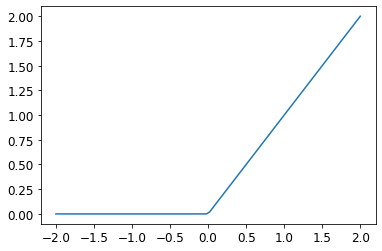

In [129]:
plot_function(F.relu)

J：深度学习中有大量的行话，包括像rectified linear unit这样的术语。正如我们在这个例子中看到的那样，这些行话的绝大部分并不复杂，只需用一行短短的代码就可以实现。现实情况是，学术界为了让他们的论文发表，他们需要让论文听起来尽可能的令人印象深刻和复杂。他们这样做的方法之一是引入专业术语。不幸的是，这样做的结果是，这个领域最终变得比它应该有的更令人生畏和难以进入。你确实必须学习这些专业术语，因为否则的话，论文和教程对你来说没有什么意义。但这并不意味着你必须发现这些行话令人生畏。只要记住，当你遇到一个你以前没有见过的词或短语时，它几乎肯定会变成指一个非常简单的概念。

基本的想法是，通过使用更多的线性层，我们可以让我们的模型做更多的计算，从而为更复杂的函数建模。但是，仅仅把一个线性层直接放在另一个线性层之后是没有意义的，因为当我们把东西相乘，然后多次相加时，可以用把不同的东西相乘，然后只相加一次来代替! 也就是说，一连串任意数量的线性层可以用一组不同参数的单一线性层来代替。

但如果我们在它们之间放一个非线性函数，比如说最大，那么这就不再是真的了。现在，每个线性层实际上在某种程度上与其他线性层解耦，可以做自己有用的工作。max函数特别有趣，因为它作为一个简单的if语句运行。

S: 在数学上，我们说两个线性函数的组合是另一个线性函数。所以，我们可以把尽可能多的线性分类器堆叠在一起，如果它们之间没有非线性函数，那就和一个线性分类器一样了。

令人惊讶的是，可以从数学上证明，这个小函数可以解决任何可计算的问题，达到任意高的准确度，如果你能找到合适的w1和w2的参数，如果你使这些矩阵足够大。对于任何任意摆动的函数，我们都可以把它近似为一堆连在一起的线；为了使它更接近摆动的函数，我们只需要使用更短的线。这就是所谓的通用近似定理。我们这里的三行代码被称为层。第一和第三层被称为线性层，第二行代码被称为不同的非线性，或激活函数。

就像上一节一样，我们可以利用PyTorch的优势，用更简单的东西代替这段代码。


In [130]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

nn.Sequential创建了一个模块，它将依次调用列出的每个层或函数。

nn.ReLU是一个PyTorch模块，它的作用与F.relu函数完全相同。大多数可以出现在模型中的函数也有相同的形式，都是模块。一般来说，只是将F替换为nn，并改变其大小写。当使用nn.Sequential时，PyTorch要求我们使用模块的版本。由于模块是类，我们必须将其实例化，这就是为什么你在这个例子中看到nn.ReLU()。( Since modules are classes, we have to instantiate them, which is why you see nn.ReLU() in this example.)

因为nn.Sequential是一个模块，所以我们可以获得它的参数，这将返回它所包含的所有模块的所有参数的列表。让我们试试吧! 由于这是一个更深入的模型，我们将使用较低的学习率和更多的epochs。

In [131]:

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [132]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.301377,0.412458,0.504416,00:00
1,0.144385,0.223927,0.808145,00:00
2,0.080781,0.113085,0.915604,00:00
3,0.053451,0.076514,0.941609,00:00
4,0.040678,0.059800,0.956820,00:00
5,0.034108,0.050438,0.964181,00:00
6,0.030310,0.044555,0.964671,00:00
7,0.027830,0.040541,0.968597,00:00
8,0.026038,0.037613,0.969578,00:00
9,0.024646,0.035379,0.971541,00:00


为了节省空间，我们在这里不显示这40行输出；训练过程被记录在learn.recorder中，输出表存储在values属性中，所以我们可以绘制出训练时的准确度。

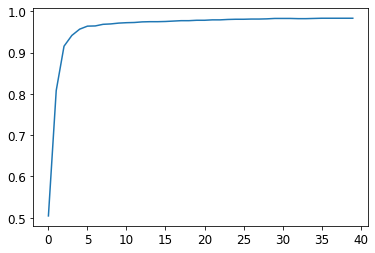

In [133]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [134]:
learn.recorder.values[-1][2]

0.983316957950592

在这一点上，我们拥有相当神奇的东西。

一个可以解决任何问题并达到任何准确度的函数（神经网络），只要有正确的参数设置

一种为任何函数找到最佳参数集的方法（随机梯度下降）。

这就是为什么深度学习可以做一些看起来相当神奇的事情，这种神奇的事情。相信这种简单技术的组合真的可以解决任何问题，是我们发现许多学生不得不采取的最大步骤之一。这似乎好得不像真的--当然，事情应该比这更难，更复杂？我们的建议是：试试吧! 我们刚刚在MNIST数据集上试过，你已经看到了结果。由于我们是自己从头开始做一切事情（除了计算梯度），你知道在幕后没有隐藏着特殊的魔法。


# Going Deeper

我们已经知道，一个单一的非线性与两个线性层足以近似任何函数。那么我们为什么要使用更深的模型呢？原因是性能。有了更深的模型（也就是有更多层的模型），我们不需要使用那么多的参数；事实证明，我们可以使用更小的矩阵和更多的层，并获得比大矩阵和少层更好的结果。

这意味着我们可以更快地训练模型，而且占用的内存更少。在20世纪90年代，研究人员非常关注通用近似定理，很少有人对一个以上的非线性进行实验。这种理论上的而非实践上的基础使该领域多年来一直受到阻碍。然而，一些研究人员确实对深度模型进行了实验，并最终能够证明这些模型在实践中可以表现得更好。最终，理论结果被开发出来，显示了为什么会发生这种情况。今天，发现有人使用只有一个非线性的神经网络是极为罕见的。

下面是我们使用在<>中看到的相同方法训练一个18层的模型时发生的情况。

In [135]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.087746,0.018014,0.995584,03:02


接近100%的准确率! 与我们的简单神经网相比，这是一个很大的区别。但正如你将在本书的其余部分学到的那样，你只需要使用一些小技巧，就可以自己从头开始获得这么好的结果。你已经知道了关键的基础部分。(当然，即使你知道了所有的技巧，你几乎总是想用PyTorch和fastai提供的预建类来工作，因为它们省去了你自己考虑所有的小细节）。 (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

Jargon Recap 

行话回顾

祝贺你：你现在知道如何从头开始创建和训练一个深度神经网络了！我们经历了相当多的步骤来达到这一点，但你可能会惊讶于它真的很简单。我们经历了相当多的步骤才走到这一步，但你可能会惊讶于它真的很简单。

既然我们已经到了这个地步，现在是一个很好的机会来定义和回顾一些专业术语和关键概念。

一个神经网络包含很多数字，但它们只有两种类型：被计算的数字，以及这些数字被计算出来的参数。这就给了我们两个最重要的行话来学习。

激活：。被计算出来的数字（包括线性和非线性层）。

参数：。随机初始化和优化的数字（也就是定义模型的数字）。

在本书中，我们将经常谈论激活和参数。请记住，它们有非常具体的含义。它们是数字。它们不是抽象的概念，而是你的模型中实际存在的具体数字。成为一名优秀的深度学习从业者的一部分是习惯于实际观察你的激活和参数的想法，并绘制它们，测试它们的行为是否正确。

我们的激活和参数都包含在张量中。这些是简单的规则形状的阵列--例如，矩阵。矩阵有行和列；我们称这些为轴或维度。张量的维数就是它的等级。有一些特殊的张量。

等级零：标量

等级一：矢量

等级二：矩阵

一个神经网络包含若干层。每层都是线性或非线性的。我们通常在神经网络中交替使用这两种层。有时人们会把线性层和其后续的非线性一起称为单层。是的，这很让人困惑。有时非线性被称为激活函数。

<>总结了与SGD相关的关键概念。

asciidoc

[[dljargon1]]

.Deep learning vocabulary

[options="header"]

|=====

| Term | Meaning

|ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers.

|Mini-batch | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).

|Forward pass | Applying the model to some input and computing the predictions.

|Loss | A value that represents how well (or badly) our model is doing.

|Gradient | The derivative of the loss with respect to some parameter of the model.

|Backward pass | Computing the gradients of the loss with respect to all model parameters.

|Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.

|Learning rate | The size of the step we take when applying SGD to update the parameters of the model.

|=====

SyntaxError: ignored